<a href="https://www.kaggle.com/code/sardorabdirayimov/notebook-for-data-contest?scriptVersionId=95726094" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 align="center" color='blue'>Forecasting Store Sales</h1>
<img src="https://i.postimg.cc/MHKWhmbM/image.png" alt="Store Sales" height='100px' width='1200' size='10%'>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        name = os.path.join(dirname, filename)
        if "train.csv" in name:
            df = pd.read_csv(name)
        elif "test.csv" in name:
            test = pd.read_csv(name)
        elif "sample_submission" in name:
            sample = pd.read_csv(name)
            
df['date'] = pd.to_datetime(df['date'])
df = df.drop(['id', 'onpromotion', 'store_nbr'], axis=1)
df = df.set_index('date').to_period('D')
df

,family,sales
date,,
2013-01-01,AUTOMOTIVE,0.000
2013-01-01,BABY CARE,0.000
2013-01-01,BEAUTY,0.000
2013-01-01,BEVERAGES,0.000
2013-01-01,BOOKS,0.000
...,...,...
2017-08-15,POULTRY,438.133
2017-08-15,PREPARED FOODS,154.553
2017-08-15,PRODUCE,2419.729


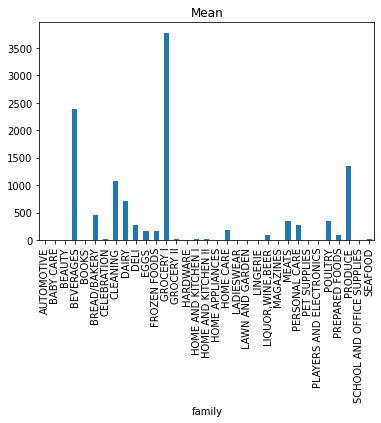

In [2]:
df.groupby(['family']).mean()['sales'].plot(kind='bar', title="Mean");

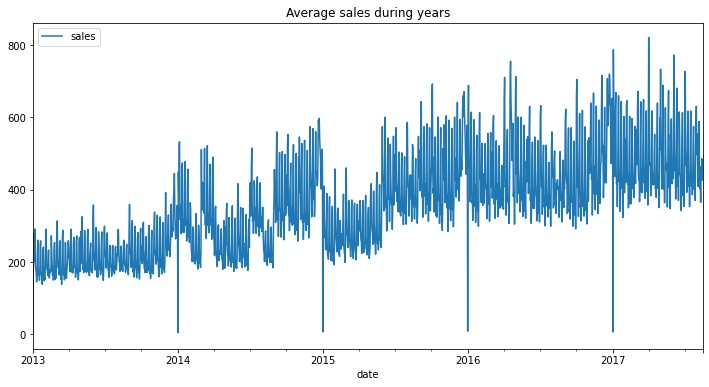

In [3]:
average_sales = pd.DataFrame(df.groupby('date').mean()['sales'])
average_sales.plot(figsize=(12,6), title="Average sales during years");

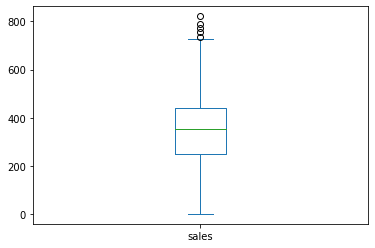

In [4]:
average_sales['sales'].plot.box();

The box-plot shows that `Sales` has some outliers. Let\`s drop them!

In [5]:
Q1 = average_sales['sales'].quantile(0.25)
Q3 = average_sales['sales'].quantile(0.75)
IQR = Q3 - Q1   
average_sales = average_sales.drop(average_sales['sales'].loc[average_sales['sales'] > Q3 + 1.5 *IQR].index)

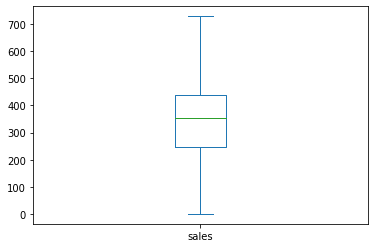

In [6]:
average_sales['sales'].plot.box();

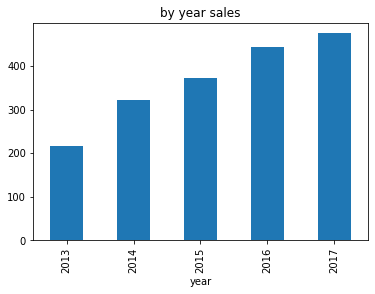

In [7]:
average_sales['year'] = average_sales.index.year
ax=average_sales.groupby('year').mean()['sales'].plot(kind='bar', title="by year sales");

`Each year the sales rate is growith slowly`

`Y variable`: `Sales`

`X variables`: `Date`

`Additional Generated values`: `constant`, `trend`, `trend_squared`, `lag_1(1st order shift)`

In [8]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess

avr_df = average_sales
dp = DeterministicProcess(
    index=avr_df.index,  
    constant=True,       
    order=2,             
    drop=True,   
)
X = dp.in_sample()
lag_1 = avr_df['sales'].shift(1)
avr_df['lag_1'] = lag_1  
X['lag_1'] = avr_df.loc[:, ['lag_1']] 

y = avr_df.loc[:, 'sales']  
y, X = y.align(X.dropna(), join='inner') 

X.head(3)

,const,trend,trend_squared,lag_1
date,,,,
2013-01-02,1.0,2.0,4.0,1.409438
2013-01-03,1.0,3.0,9.0,278.390807
2013-01-04,1.0,4.0,16.0,202.840197


In [9]:
y.head(3)

date
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
Freq: D, Name: sales, dtype: float64

# 1st Model | Linear Regression

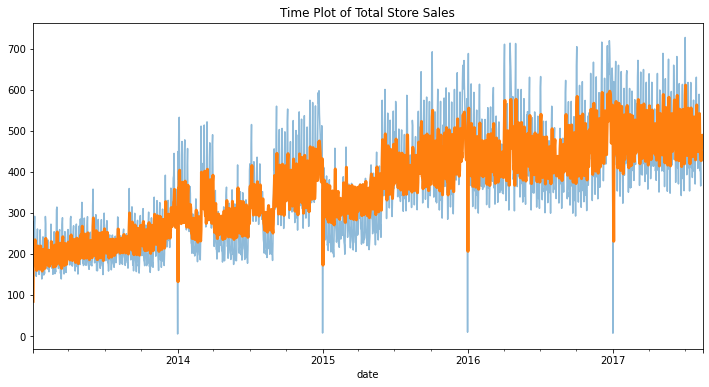

In [10]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(alpha=0.5, figsize=(12,6))
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
print("MSE: ",mean_squared_error(y,y_pred), "MAPE:", mean_absolute_percentage_error(y,y_pred))

MSE:  5874.983979965591 MAPE: 0.3113955267974947


# 2nd Model | Linear Model with extra features

            const  trend  trend_squared       lag_1       lag_2       lag_3
date                                                                       
2013-01-04    1.0    4.0           16.0  202.840197  278.390807    1.409438
2013-01-05    1.0    5.0           25.0  198.911154  202.840197  278.390807
2013-01-06    1.0    6.0           36.0  267.873244  198.911154  202.840197


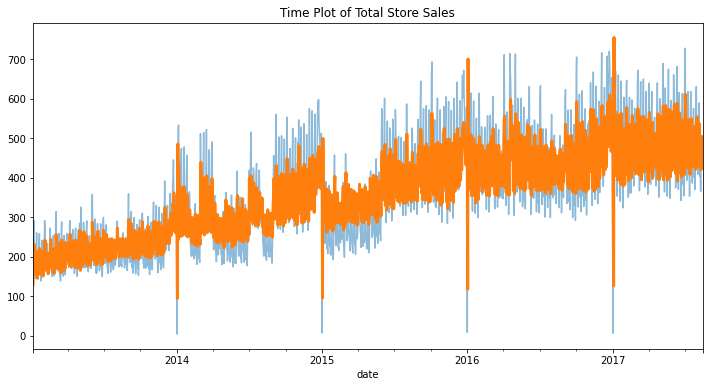

In [12]:
avr_df = average_sales
dp = DeterministicProcess(
    index=avr_df.index,  
    constant=True,      
    order=2,        
    drop=True,      
)
X = dp.in_sample()
lag_1 = avr_df['sales'].shift(1)
avr_df['lag_1'] = lag_1  
X['lag_1'] = avr_df.loc[:, ['lag_1']]  
lag_2 = avr_df['sales'].shift(2)
avr_df['lag_2'] = lag_2  
X['lag_2'] = avr_df.loc[:, ['lag_2']] 
lag_3 = avr_df['sales'].shift(3)
avr_df['lag_3'] = lag_3 
X['lag_3'] = avr_df.loc[:, ['lag_3']] 
y = avr_df.loc[:, 'sales']  
y, X = y.align(X.dropna(), join='inner') 
print(X.head(3))

model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(alpha=0.5, figsize=(12,6))
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
print("MSE: ",mean_squared_error(y,y_pred), "MAPE:", mean_absolute_percentage_error(y,y_pred))

MSE:  5367.006189877809 MAPE: 0.2934348609309791


# Conclusion 
`MSE` and `MAPE` scores are better then previous model, because 2nd model has more features.

According to Visualization of prediction, 2nd model performs more accurately.

Author: Abdirayimov Sardor